In [10]:
%matplotlib inline

import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
jtplot.style(theme='onedork')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

# reset default matplotlib rcParams
jtplot.reset()

**辅助函数**

In [73]:
def find_most_common(df, cat_col):
    '''查找DataFrame中指定列的最频繁值，一般用于填充缺失值'''
    tmp = df.groupby(cat_col)[cat_col].agg(len)
    tmp.sort_values(ascending=False, inplace=True)
    return tmp.index[0]

def find_miss_feat(df):
    '''传入一个DataFrame, 返回其中含有缺失值的列信息'''
    return df.dtypes[df.isnull().any(axis=0)==True]

def get_feats_name(df):
    '''传入一个DataFrame，返回数值和分类变量的列名，不包括ID和Target'''
    id_target = ['SK_ID_CURR', 'TARGET']
    cat_feat = [c for c in df.columns[df.dtypes == 'O'] if c not in id_target]
    num_feat = [c for c in df.columns[df.dtypes != 'O'] if c not in id_target]
    return cat_feat, num_feat

# 绘图函数
def plot_dist(df, feats, rotation=45):
    '''绘制feats中每个变量的数据分布
        如果变量是分类特征或者数值特征但其唯一值<=10: 先做value_counts，再绘制其对应的barplot，
        如果唯一值个数小于
        否则，直接绘制其dist分布
    '''
    # 随机设置图像颜色
    tmp = sns.color_palette('muted');shuffle(tmp);
    with sns.color_palette(tmp):
        _rows, _cols = len(feats) // 3 + 1 if len(feats) % 3 else len(feats) // 3, 3
        fig, ax = plt.subplots(_rows, _cols, figsize=(15, _rows * 4))
        for _id, c in enumerate(feats):
            if _rows > 1:
                _ax = ax[_id // _cols, _id % _cols]
            else:
                _ax = ax[_id % _cols]
            if df[c].dtype == 'O' or df[c].unique().shape[0] <= 10:
                tmp = df[c].value_counts()
                g = sns.barplot(x=tmp.index, y=tmp, ax=_ax)
                g.set_xticklabels(g.get_xticklabels(), rotation=45)
                _ax.set(title=c)
            else:
                sns.distplot(df[c], ax=_ax)
        plt.tight_layout()

def plot_cat(df, cat, feats):
    '''绘制不同cat值对应的feats的数据分布'''
    # 随机设置图像颜色
    tmp = sns.color_palette('muted');shuffle(tmp);
    
    _rows, _cols = len(feats) // 3 + 1 if len(feats) % 3 else len(feats) // 3, 3
    fig, ax = plt.subplots(_rows, _cols, figsize=(15, _rows * 4))
    with sns.color_palette(tmp):    
        for _id, c in enumerate(feats):
            if _rows > 1:
                _ax = ax[_id // _cols, _id % _cols]
            else:
                _ax = ax[_id % _cols]
            if df[c].dtype == 'O' or df[c].unique().shape[0] <= 10:
                # tmp = df.groupby([cat, c])[c].agg(len)
                # _ = sns.countplot(x=c, data=df, hue=cat, ax=_ax)
                _ = sns.countplot(
                    x=c, data=df.loc[df[c].notnull(), [cat, c]], hue=cat, ax=_ax)
            else:
                # 如果是数值型特征，就按照cat分类，依次绘制其分布图
                for v in df[cat].unique():
                    # _ = sns.distplot(df.loc[df[cat]==v, c], ax=_ax)
                    _ = sns.distplot(
                        df.loc[(df[cat]==v) & (df[c].notnull()), c], ax=_ax)
        plt.tight_layout()

## 获取数据

In [4]:
from pathlib import Path

bureau = pd.read_csv(Path.cwd() / 'input' / 'bureau.csv')
bureau_balance = pd.read_csv(Path.cwd() / 'input' / 'bureau_balance.csv')

previous_app = pd.read_csv(Path.cwd() / 'input' / 'previous_application.csv')
repayments = pd.read_csv(Path.cwd() / 'input' / 'installments_payments.csv')
credit_card = pd.read_csv(Path.cwd() / 'input' / 'credit_card_balance.csv')
pos_cash = pd.read_csv(Path.cwd() / 'input' / 'POS_CASH_balance.csv')

In [58]:
train = pd.read_csv(Path.cwd() / 'input' / 'application_train.csv')

In [59]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(train, test_size=0.1, random_state=42)
train_set.reset_index(inplace=True, drop=True)
test_set.reset_index(inplace=True, drop=True)

## Bureau数据分析

---

* CREDIT_CURRENCY: 共有4个值，99.9%都是`currency 1`, 0.07%是`currency 2`
* CREDIT_DAY_OVERDUE: 竟然没有空值=。=, 99.75%都是0
* DAYS_CREDIT_ENDDATE: 借贷记录结束日期
* DAYS_ENDDATE_FACT: 借贷记录实际的结束日期，只有closed的有记录
* AMT_CREDIT_MAX_OVERDUE: 65%都是空值，非空部分80%都是0
* CNT_CREDIT_PROLONG: 99.4%的值都是0
* AMT_CREDIT_SUM: 该借贷记录的总额，见下边的describe
* AMT_CREDIT_SUM_DEBT: 与借贷记录对应的债务总额
* AMT_CREDIT_SUM_LIMIT: 信用额度？
* AMT_CREDIT_SUM_OVERDUE: 预期总额
* CREDIT_TYPE: 信贷类型

In [57]:
bureau[bureau['SK_ID_CURR']==436048]
# bureau.sample(10)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1014305,436048,5131700,Closed,currency 1,-745,0,1081.0,-380.0,NaN,0,837000.0,0.0,0.0,0.0,Consumer credit,-54,NaN
1014306,436048,5131701,Closed,currency 1,-1495,0,-1191.0,-1191.0,6619.275,0,58455.0,0.0,0.0,0.0,Consumer credit,-1191,NaN
1402569,436048,5131699,Closed,currency 1,-413,0,-48.0,-382.0,NaN,0,112500.0,0.0,0.0,0.0,Consumer credit,-54,NaN


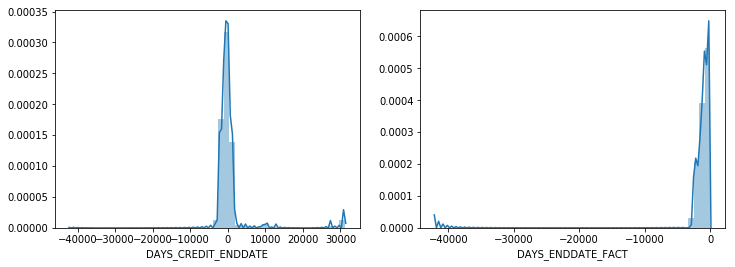

In [32]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(bureau['DAYS_CREDIT_ENDDATE'].dropna(), ax=ax0)
sns.distplot(bureau['DAYS_ENDDATE_FACT'].dropna(), ax=ax1)

In [28]:
(bureau['CREDIT_DAY_OVERDUE']==0).sum() / bureau.shape[0]

0.997543153572419

In [41]:
(bureau['AMT_CREDIT_MAX_OVERDUE'].isnull()).sum() / len(bureau)

0.6551326359159837

**AMT_CREDIT_SUM**

In [50]:
bureau['AMT_CREDIT_SUM'].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
AMT_CREDIT_SUM,1716415.0,354994.591918,1.149811e+06,0.0,51300.0,125518.5,315000.0,585000000.0


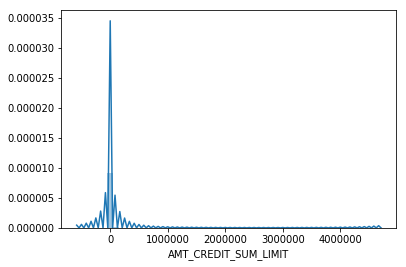

In [53]:
sns.distplot(bureau['AMT_CREDIT_SUM_LIMIT'].dropna())

**CREDIT_TYPE**

In [55]:
bureau['CREDIT_TYPE'].value_counts()

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                                  1
Interbank credit                                      1
Name: CREDIT_TYPE, dtype: int64

### 匹配目标值

In [65]:
bureau2 = pd.merge(
    bureau,
    train_set[['SK_ID_CURR', 'TARGET']],
    on='SK_ID_CURR',
    how='inner')

In [66]:
bureau2.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,TARGET
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,0
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,0
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,0
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,0
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,0


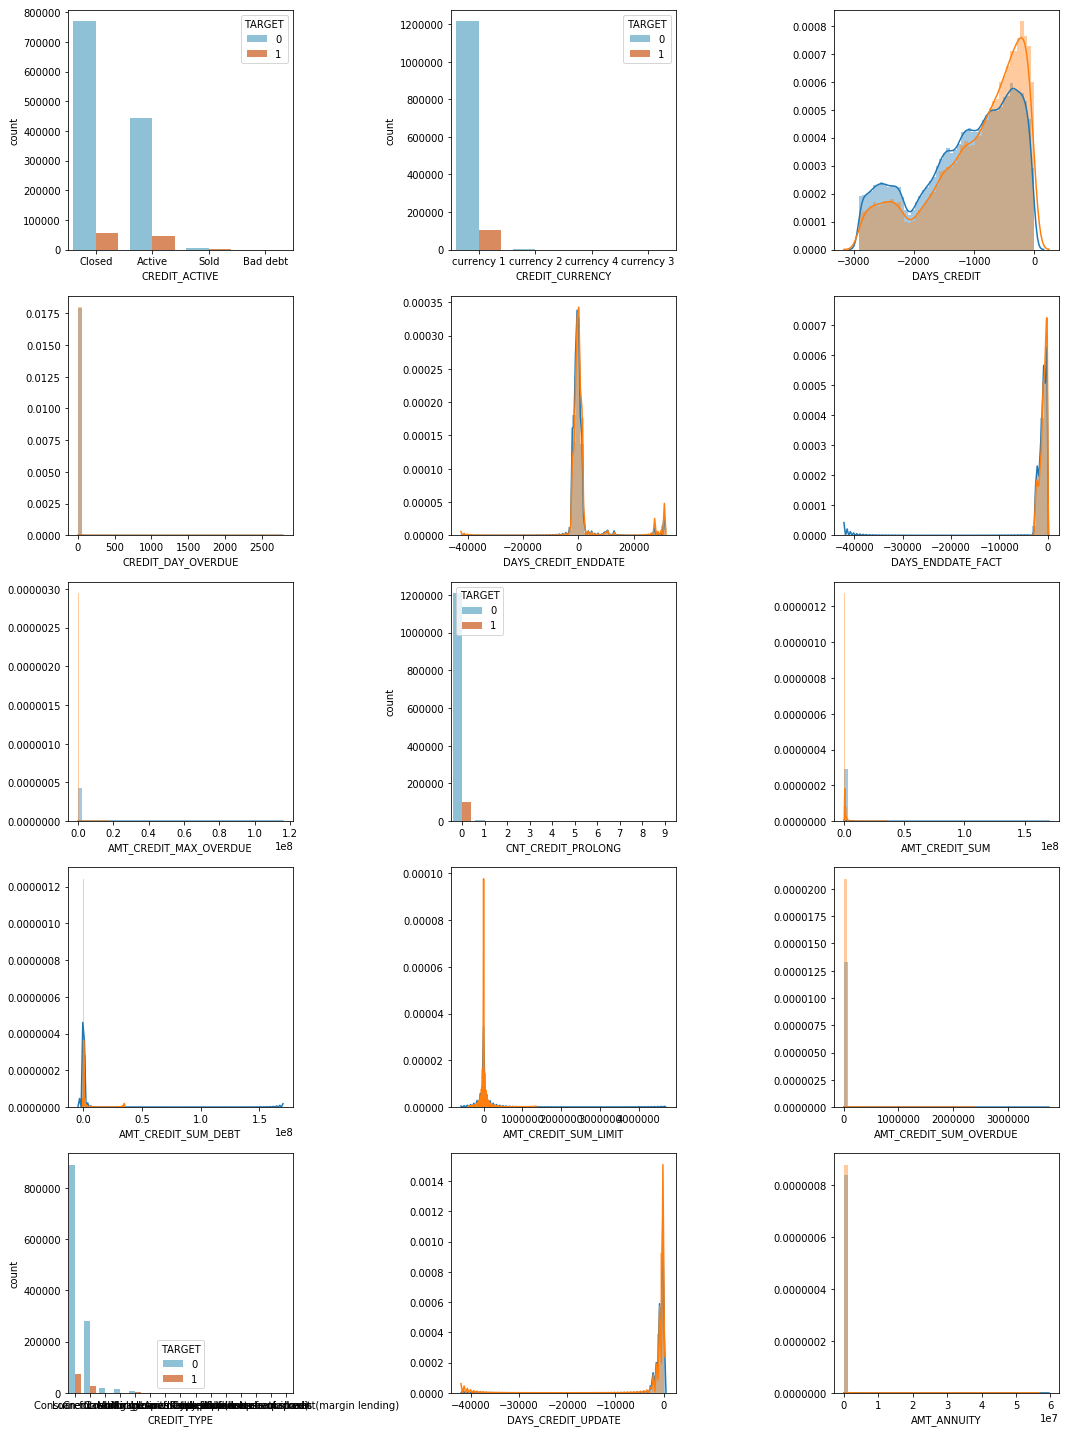

In [74]:
plot_cat(bureau2,
         'TARGET',
         bureau2.drop(['SK_ID_CURR', 'SK_ID_BUREAU', 'TARGET'], axis=1).columns)